In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [29]:
data_path = '/home/sean/mea data/023/023_170619_1118(001).csv'
#'/Users/kelsey/Dropbox/Lab/maestro_data/023/023_spk_freq_table.csv'
data_table = pd.read_csv(data_path)
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

In [30]:
condition_cols = {
    'DTX_100nM': 1,
    'DTX_10nM': 2,
    'Ba_0.1mM': 3,
    'PTX_0.5uM': 4,
    'KCl_0.1mM': 5,
    'NaCl_60mM': 6,
    'DMSO': 7,
    'Ctrl': 8
}

def create_well_assignment_filter(cond_name):
    def well_assignment_filter(unit_name):
        col = mc.get_col_number(unit_name)
        return col == condition_cols[cond_name]
    return well_assignment_filter

well_filter_dict = {cond_name: create_well_assignment_filter(cond_name) for cond_name in condition_cols.iterkeys()}


In [31]:
cat_table = plotting.construct_categorized_dataframe(data_table, well_filter_dict)
cat_table['spike_freq'] = cat_table['spike_freq']/300 # convert from spikes/five minutes to spikes/second
cat_table['spike_freq'] = plotting.smooth(cat_table['spike_freq'], kernel_size=20) # smooth using a 20 minute kernel

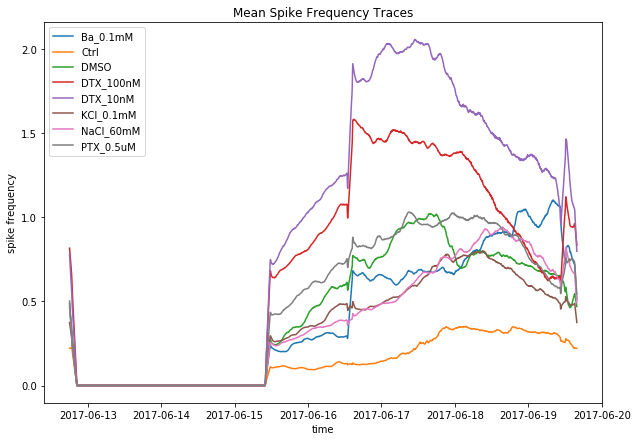

In [32]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table)

In [33]:
cat_table = cat_table.query('time > "2017-06-15 10:37:05"') #get rid of times before start of baseline recording

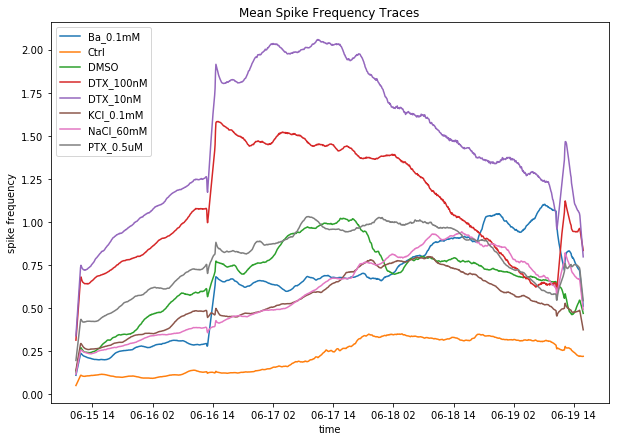

In [34]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table)

In [35]:
#baseline between 2017-06-15 12:00:05 and 2017-06-16 13:10:05

baseline_table = cat_table.query('time > "2017-06-15 12:00:05"').query('time < "2017-06-16 13:10:05"')
stim_table = cat_table.query('time > "2017-06-16 13:50:05"')


/home/sean/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


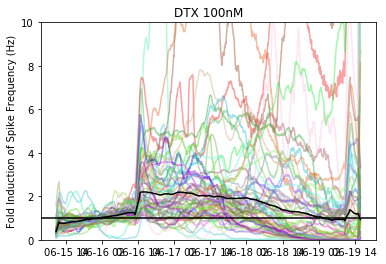

In [89]:
import random 


c = cat_table.query('condition=="DTX_100nM"')
b = baseline_table.query('condition=="DTX_100nM"')
s = stim_table.query('condition=="DTX_100nM"')
c_filter = pd.DataFrame()
b_filter = pd.DataFrame()




for unit_name in c['unit_name'].unique():
    unit = c.query('unit_name == @unit_name')
    unit_b = b.query('unit_name == @unit_name')
    unit_s = s.query('unit_name == @unit_name')
    meanOfBaseline = np.mean(unit_b['spike_freq'])
    varOfBaseline = (max(unit_b['spike_freq'])-min(unit_b['spike_freq']))/meanOfBaseline
    meanAfterDrug = np.mean(unit_s[0:60]['spike_freq'])
    #print(varOfBaseline < 2.5)
    if meanOfBaseline < meanAfterDrug and varOfBaseline < 2.5 and meanOfBaseline > 0.01: 
        plt.plot(unit['time'], unit['spike_freq']/meanOfBaseline, color=(random.random(), random.random(), random.random(), .4))
        c_filter = c_filter.append(unit, ignore_index=True)
        b_filter = b_filter.append(unit_b, ignore_index=True)
    else:
        continue


plt.ylabel('Fold Induction of Spike Frequency (Hz)')
plt.ylim(0,10)
plt.axhline(y=1, xmin=0, xmax=1, hold=None, color='black')
mean_freq_traces = c_filter.groupby(('condition', 'time'))['spike_freq'].mean()
mean_freq_traces = mean_freq_traces.rename('spike frequency').reset_index() # Convert the multiindexed series back to a dataframe
mean_freq_traces_b = b_filter.groupby(('condition', 'time'))['spike_freq'].mean()
mean_freq_traces_b = mean_freq_traces_b.rename('spike frequency').reset_index() # Convert the multiindexed series back to a dataframe

plt.title('DTX 100nM')
meanOfMean = np.mean(mean_freq_traces_b['spike frequency'])
plt.plot(mean_freq_traces['time'], mean_freq_traces['spike frequency']/meanOfMean, color=(0,0,0))

plt.show()




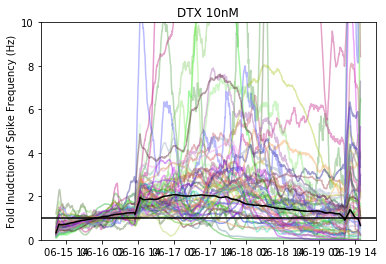

In [87]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "DTX_10nM", 'DTX 10nM')

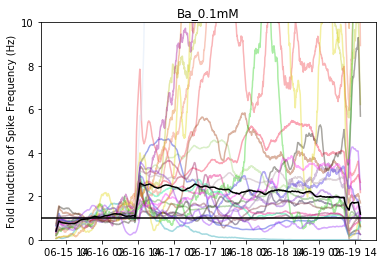

In [79]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "Ba_0.1mM", 'Ba_0.1mM', var=2.5) 

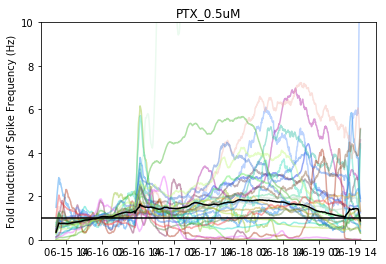

In [80]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "PTX_0.5uM", 'PTX_0.5uM', var=2.5)


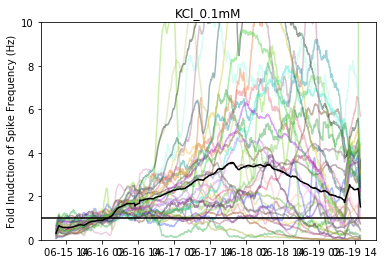

In [81]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "KCl_0.1mM", 'KCl_0.1mM')

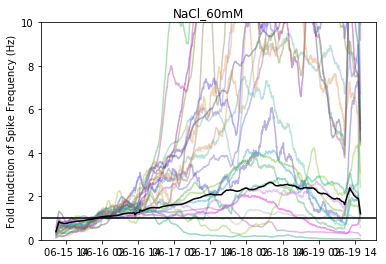

In [82]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "NaCl_60mM", 'NaCl_60mM')

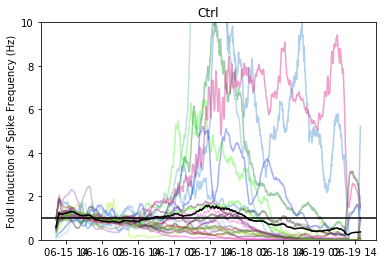

In [100]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "Ctrl", 'Ctrl', ind_filter = False)

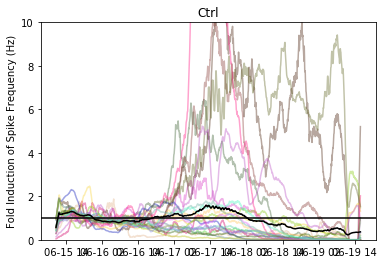

In [101]:
# to check that plotting.foldInductionPlusMean works
plotting.foldInductionPlusMean_ctrl(cat_table, baseline_table, stim_table, "Ctrl", 'Ctrl')

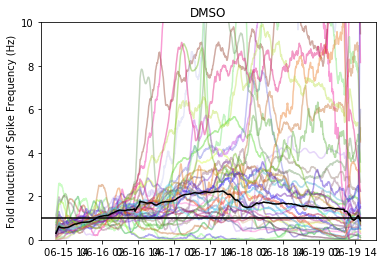

In [84]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "DMSO", 'DMSO', ind_filter = False)

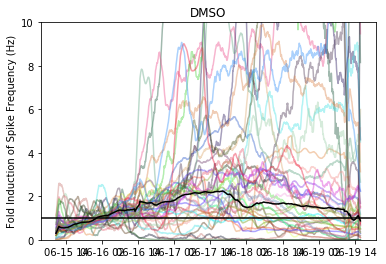

In [85]:
# to check that plotting.foldInductionPlusMean works
plotting.foldInductionPlusMean_ctrl(cat_table, baseline_table, stim_table, "DMSO", 'DMSO')